In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import os


Translation

In [ ]:
img = cv2.imread("messi.jpg")

assert img is not None
h, w = img.shape[:2]
m = np.float32([[1, 0, 50], [0, 1, 50]])
dst = cv2.warpAffine(img, m, (w, h))

cv2.imshow("original", img)
cv2.imshow("translate", dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

Transformation of 3D to 2D point 

In [ ]:
fx = 800
fy = 800
cx= 640
cy = 480


camera_metrix = np.array([[fx, 0, cx],
                         [0, fy, cy],
                         [0,0,1]], np.float32)
dist_coeff = np.zeros((5, 1), np.float32)
x, y, z = 10, 20 ,30
point_3d = np.array([[[x, y, z]]], np.float32)
rvec= np.zeros((3, 1), np.float32)
tvec= np.zeros((3, 1), np.float32)
point_2d=cv2.projectPoints(point_3d,rvec, tvec, camera_metrix,dist_coeff)

print(" 2D point ", point_2d)


Capture and save images 

In [ ]:
cap = cv2.VideoCapture(0)
count=0
while True:
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)

    if ret is None:
        print(ret)
        break
    cv2.imshow("take image ", frame)
    if cv2.waitKey(1) & 0xff ==ord("q"):
        break
    if cv2.waitKey(1) & 0xff ==ord("s"):
        name=fr"C:\Users\USER\Documents\code_tutorial\images\img_{count}.png"
        cv2.imwrite(name, frame)
        print("Image successfully saved!!!")
        count+=1
cap.release()
cv2.destroyAllWindows()

camera calibration

In [5]:
checkerboard = (6, 9)

criteria  = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_MAX_ITER, 30 , 0.001)
real_world=[]
image_point=[]

object3dp=np.zeros((1, checkerboard[0] * checkerboard[1], 3), np.float32)

object3dp[0, :, :2] = np.mgrid[0:checkerboard[0], 0:checkerboard[1]].T.reshape(-1, 2)
p_image= None

images = glob.glob("images\*.png")
for filename in images:
    image = cv2.imread(filename)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, corner = cv2.findChessboardCorners(image_gray, checkerboard,cv2.CALIB_CB_ADAPTIVE_THRESH  
                    + cv2.CALIB_CB_FAST_CHECK + 
                    cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret==True:
        real_world.append(object3dp)

        corner2= cv2.cornerSubPix(image_gray, corner, (11, 11), (-1, -1), criteria)
        image_point.append(corner2)
        image = cv2.drawChessboardCorners(image, checkerboard,corner,ret)
    cv2.imshow("image", image)
    cv2.waitKey(0)
cv2.destroyAllWindows()

h, w = image.shape[:2]

ret, matrix, dist, rvect, tvect =cv2.calibrateCamera(real_world, image_point, (w, h), None, None)
print("camera metrix ")
print(matrix)



camera metrix 
[[1.57179407e+03 0.00000000e+00 3.63173251e+02]
 [0.00000000e+00 1.68272524e+03 2.34303784e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Undistort

In [7]:
img = cv2.imread("calib_radial.jpg")
print(img.shape )

h, w = img.shape[:2]
newcameraMatrix, roi=cv2.getOptimalNewCameraMatrix(matrix, dist, (w, h), 1, (w, h))
print("ROI \n", roi)
print("NEW Matrix\n ", newcameraMatrix)

(454, 398, 3)
ROI 
 (6, 4, 390, 446)
NEW Matrix
  [[1.55655863e+03 0.00000000e+00 3.63544555e+02]
 [0.00000000e+00 1.67246067e+03 2.32136435e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [8]:
undist= cv2.undistort(img, matrix, dist, None, newcameraMatrix)
# print(undist)

x, y, w, h = roi
undist =undist[y:y+h, x:x+w]
# cv2.imshow("original image ", img)
# cv2.imshow("undistort image ", undist)
# cv2.waitKey(0)

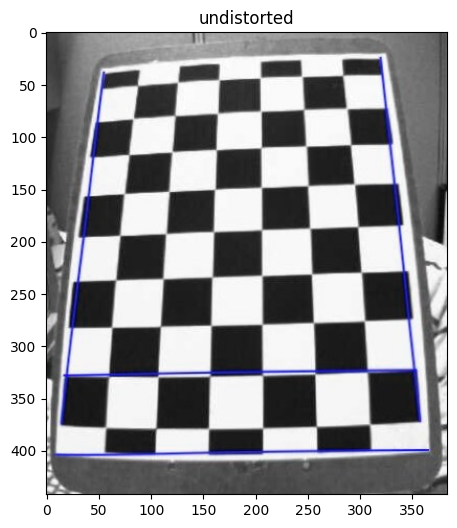

In [11]:
# undistort
mapx, mapy = cv2.initUndistortRectifyMap(matrix, dist, None, newcameraMatrix, (w,h), 5)
dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
plt.figure(figsize =(10, 6))
cv2.imwrite('calibresult.png', dst)
plt.title("undistorted")
plt.imshow(dst)
plt.show()

In [12]:
mean_error = 0
for i in range(len(real_world)):
    imgpoints2, _ = cv2.projectPoints(real_world[i], rvect[i], tvect[i], matrix, dist)
    error = cv2.norm(image_point[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(real_world)) )

total error: 0.1866159040780191


In [10]:
import json
real_world_2 = np.array(real_world, np.float32).reshape(-1, 3)
rvect_2=np.array(rvect, np.float32)
tvect_2 = np.array(tvect, np.float32)
dist_2 = np.array(dist, np.float32)
matrix_2 = np.array(matrix, np.float32)
files={'real_world': real_world_2.tolist(),
       'matrix': matrix.tolist(),
       'dist': dist_2.tolist(),
        "matrix": matrix_2.tolist(),
    "dist": dist.tolist(),
    "rvect": [r.flatten().tolist() for r in rvect],  # Flatten and convert to list
    "tvect": [t.flatten().tolist() for t in tvect]   # Flatten and convert to list
       }
# type(tvect)
with open('camera_data.json', 'a+') as j:
    json.dump(files, j, indent=5)


In [19]:
import json
import numpy as np
import cv2

# Load camera parameters from JSON
with open('camera_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert lists back to NumPy arrays
real_world_2 = np.array(loaded_data["real_world"], dtype=np.float32)
matrix_2 = np.array(loaded_data["matrix"], dtype=np.float32).reshape(-1, 3)
dist_2 = np.array(loaded_data["dist"], dtype=np.float32)
rvect_2 = [np.array(r, dtype=np.float32).reshape(3, 1) for r in loaded_data["rvect"]]
tvect_2 = [np.array(t, dtype=np.float32).reshape(3, 1) for t in loaded_data["tvect"]]

# Project 3D points to 2D
point_2d, _ = cv2.projectPoints(real_world_2, rvect_2[0], tvect_2[0], matrix_2, dist_2)

# Save the 2D points to a text file
n_point=point_2d[0][0]
x, y = n_point[0], n_point[1]
print(f"{x:.2f}, {y:.2f}")

# with open("point_2d.txt", "w") as f:

#     for pt in point_2d:
#         point=pt[0]
#         x, y =point[0], point[1]
#         # print(f"{x:.2f}, {y:.2f}\n")
#         # x, y = pt[0][0]
#         f.write(f"{x:.2f}, {y:.2f}\n")


516.19, 111.38


In [10]:
matrix_2

array([[1.5717941e+03, 0.0000000e+00, 3.6317325e+02],
       [0.0000000e+00, 1.6827252e+03, 2.3430379e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

image distance 

In [21]:
import cv2
import numpy as np



# Undistort image point
image_point = np.array([[x, y]], dtype='float32')
undistorted_point = cv2.undistortPoints(image_point, matrix_2, dist_2)
x_normalized, y_normalized = undistorted_point[0][0]

# Calculate distance (assuming known real-world size and scaling)
real_world_size = 40# i used 40mm checkboard 
scale = real_world_size / np.sqrt(x_normalized**2 + y_normalized**2)
distance = real_world_size / scale
print(scale)

print(f"Distance to camera: {distance}")


332.21684249781833
Distance to camera: 0.12040328750118284


In [22]:
import cv2
import numpy as np


real_world_size_mm = 40  # Known size of checkerboard square in mm
real_world_size_m = real_world_size_mm / 1000  # Convert mm to meters

# Image point

image_point = np.array([[x, y]], dtype='float32')

# Undistort image point
undistorted_point = cv2.undistortPoints(image_point, matrix_2, dist_2)
x_normalized, y_normalized = undistorted_point[0][0]

# Convert normalized coordinates to meters
focal_length = matrix_2[0, 0]  # Assuming fx = fy, and focal length is in pixels
sensor_width_mm = 36  # Example sensor width, adjust as needed
sensor_width_m = sensor_width_mm / 1000

# Calculate the real-world distance
distance = (real_world_size_m * focal_length) / np.sqrt(x_normalized**2 + y_normalized**2)
print(f"Distance to camera: {distance} meters")


Distance to camera: 522.1764621227211 meters
